# Part I. Toy model 

Let's generate a very simple dataset to get familiar with PyMC3. We begin, as usual, loadaing traditional Python libraries:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd  
import seaborn as sns  
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)

We now define a function to generate a linear or quadratic model with the option of adding noisy data. Such a noise will help us to showcase the use of PyMC3

In [2]:
def generate_data(n=20, a=1, b=1, c=0, latent_error_y=10):  
    ''' 
    Create a toy dataset based on a simple linear/quadratic model 
    that we might imagine is a noisy physical process

    Model form: y ~ a + bx + cx^2 + e
    '''

    # generate linear or quadratic model
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## add latent error noise
    df['y'] += rndst.normal(0,latent_error_y,n)

    return df

We now generate data based on the previous function and plot. Here our model is:

$$
    \begin{equation}
        y = \beta^{T}x + \epsilon
    \end{equation}
$$

where 

$$ 
    \beta = [5 , 2]^{T} 
$$

and the variance of the noisy background is 

$$
    \sigma^{2} = 30
$$

In [42]:
df = generate_data(a=5, b=2, latent_error_y=30)

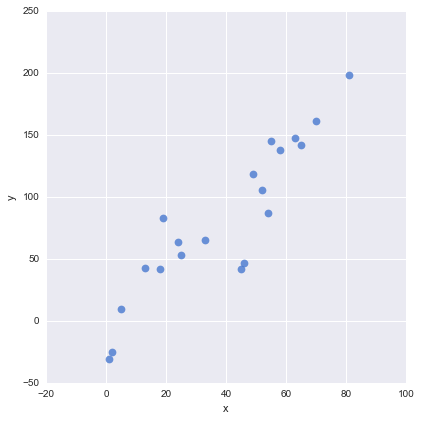

In [43]:
# `lmplot()` fits and plot a linear regression line by default.
g = sns.lmplot(x='x', y='y', data=df, fit_reg=False 
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

Let's create and fit a frequentist ordinary least squares (OLS) model. For this purpose we will use the statsmodels Python library. We will also use patsy for symbolic model specification.

In [34]:
import patsy as pt  
import statsmodels.api as sm

In [44]:
## first, encode model specification as design matrices
fml = 'y ~ 1 + x'  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe'
                              ,NA_action='raise')

## We now fit OLS model and print results
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     91.49
Date:                Tue, 04 Oct 2016   Prob (F-statistic):           1.76e-08
Time:                        11:33:34   Log-Likelihood:                -92.438
No. Observations:                  20   AIC:                             188.9
Df Residuals:                      18   BIC:                             190.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -9.7060     11.190     -0.867      0.3

Notice that the resulting slope, **2.35** (with standard deviation 0.246), is not too far away from the actual value **2.00.** The intercept, however, is very off from the actual value: A **-9.71** (with standard deviation 11.190) predicted value versus the actual **5.00.**

Let's now plot the posterior prediction. This time we make use of the fitting feature provided by lmplot

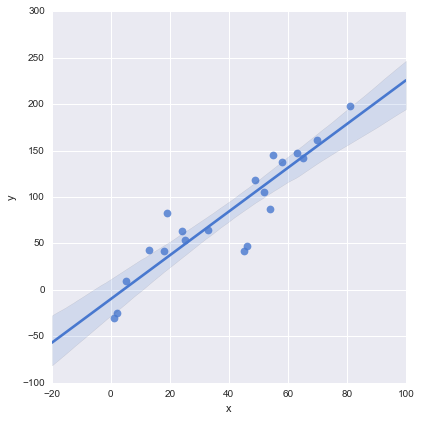

In [45]:
g = sns.lmplot(x='x', y='y', data=df, fit_reg=True  
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

We will now create and fit a Bayesian OLS model using PyMC3. We define a model specification and take samples of $\beta$ from the *joint probability distribution* and minimize the log-loss when computed against the *posterior predictive distribution.*

In [46]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

* We use a **generalized linear model.** The generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for response variables that have error distribution models other than a normal distribution. 


* We optimize to find the Max A-Posteriori (MAP) estimate of the joint probability distribution, and thus a good starting point for the sampler.


* We use the NUTS (No-U-Turn Sample) sampler to take 3000 samples from the joint probability distribution of $ \beta $ and converge via evaluating and iteratively minimising the loss on the posterior predictive distribution $ \hat{y} $ with respect to the true values $ y $.

In [53]:
with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.Normal())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)

    ## take samples using NUTS. These are the traces we will need for visualization
    trc_ols = pm.sample(3000, start=start_MAP, step=pm.NUTS())

Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 3000 of 3000 complete in 4.5 sec

The results of the above are in the form of a *trace* for each $\beta$ parameter, each 3000 samples long. We now visualize the trace of the last 1000 samples. 

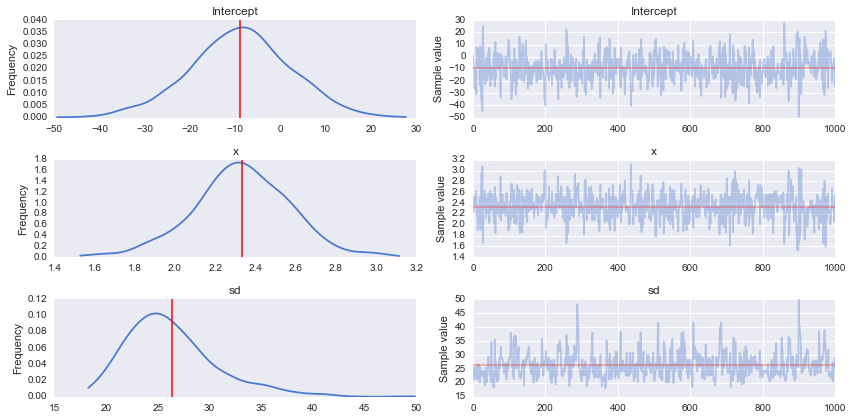

In [54]:
ax = pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),  
    lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()})

* On the left-hand side we show the traces form a *marginal distribution* on each parameter letting us declare distributional statistics directly from the data with no assumptions about their functional form.


* On the right-hand side we show raw trace values that can be used to create 1000 posterior predictions of $ y $ for any $ x $. This takes place without any assumptions about the functional form. 

Lets take a look at the parameter values

In [56]:
print(pm.df_summary(trc_ols[-1000:]))  

                mean         sd  mc_error    hpd_2.5   hpd_97.5
Intercept  -8.914755  11.201074  0.508844 -34.664304  10.488089
x           2.331739   0.244515  0.011104   1.796886   2.765275
sd         26.323931   4.471049  0.251412  19.050152  35.866447


Here is the summary:

* Intercept:  $ \mu = -8.91 $ , $ \sigma = 11.20 $ 
* Slope ($ x $) $ \mu = 2.33 $ , $ \sigma = 0.25 $
* Gaussian noise: $ \mu = 26.33 $ , $ \sigma = 4.47 $

Notice that the Bayesian OLS has made very similar estimates of the parameter values as the Frequentist OLS. This is good news as both models are quite similar. In addition, we have this time an estimate for the parameter of the noise we introduced in our linear data; close to the actual value of $30.$

In addition:

* **Frequentist approach**. In the Frequentist ordinary least-square model the *confidence intervals* are created by fitting a Normal distribution over the point-estimate maximum likelihood estimate values of each parameter.


* **Bayesian approach**. In the Bayesian inferential method, we can simply use the distribution of samples (after convergence) to learn the uncertainty in the parameter values. This is, we have real intervals, **credible regions (CR)** on the estimates of the parameter values.

Let's take a look at model posterior prediction. For this goal we start defining a function:

In [61]:
def plot_posterior_credible_regions(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    plot the posterior predictions from given traces
    '''

    ## Get traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## Recreate likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Blues')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)


Let's invoke the previous function:

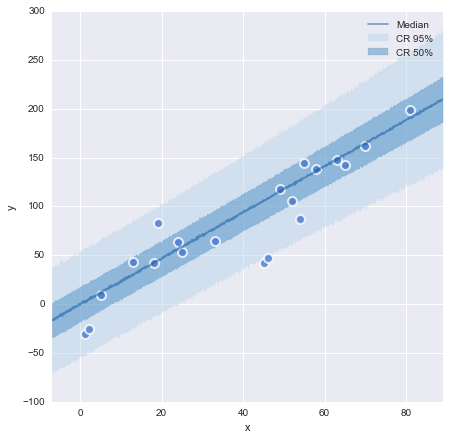

In [63]:
xlims = (df['x'].min() - np.ptp(df['x'])/10  
                 ,df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_credible_regions(mdl_ols, trc_ols, df, xlims)

We have used parameter trace values to generate new predictions $ \hat{y} $ according to the model specification. We have then measured credible regions over that distribution and overplotted a line of fit and credible regions (CR) on the original datapoints. The two credible regions shown are at 50% and 95%. This means that we expect 50% of the datapoints to fall within the 50% CR and likewise for the 95% CR. 